This is a starter file of network simulation

## Import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from spice import solve_quasi_3D


	Welcome to Solcore - version 5.5.2
	Copyright (c) 2018, Imperial College London. All rights reserved.
	Software released under the GNU Lesser General Public License.

No module named 'solcore.poisson_drift_diffusion.ddModel'


## Load the pattern of the contact

In [2]:
contactsMask = imread('masks_sq.png')

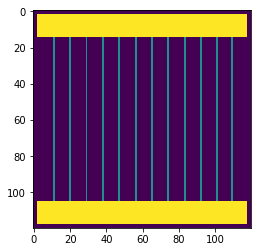

In [3]:
plt.imshow(contactsMask)

## Reduce the shape to 1/4 because of symmetry

In [4]:
nx, ny = contactsMask.shape
# For symmetry arguments (not completely true for the illumination), we can mode just 1/4 of the device and then
# multiply the current by 4
contactsMask = contactsMask[int(nx / 2):, int(ny / 2):]

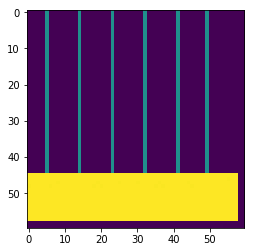

In [5]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [6]:
from os.path import join
import os
this_path=os.getcwd()
# both csv and png file are supported.
# image_file=join(this_path,"Illumination profile_20180926.png")
image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [7]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [8]:
img=load_illumination(image_file)

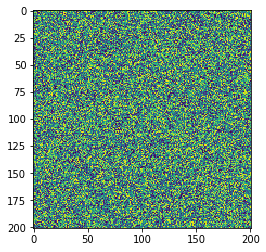

In [9]:
plt.imshow(img)

### Reduce the shape to 1/4

In [10]:
illuminationMask=img
illuminationMask=illuminationMask[int(img.shape[0] / 2):, int(img.shape[1] / 2):]

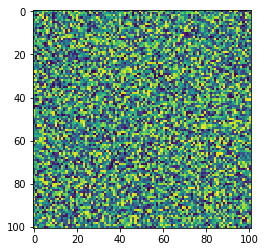

In [11]:
plt.imshow(illuminationMask)

In [12]:
np.max(illuminationMask)

99.0

In [13]:
illuminationMask.shape

(101, 101)

In [14]:
from scipy.interpolate import interp2d
def resize(image,new_shape):
    xx=np.arange(0,image.shape[0],1)
    yy=np.arange(0,image.shape[1],1)
    image_func=interp2d(xx,yy,image)
    x_new=np.linspace(0,image.shape[0],num=new_shape[0])
    y_new=np.linspace(0,image.shape[1],num=new_shape[1])
    
    resized_image=image_func(x_new,y_new)
    return resized_image

### Downsample the illumination profile
This time we resample the illumination profile and the mask profile to both 50x50 pixels.

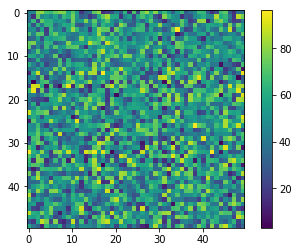

In [15]:
# The size of the image to downsample to
target_shape=(50,50)
resized_illuminationMask=resize(illuminationMask,target_shape)
plt.imshow(resized_illuminationMask)
plt.colorbar()

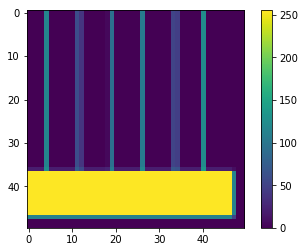

In [16]:
resized_contactsMask=resize(contactsMask,target_shape)
plt.imshow(resized_contactsMask)
plt.colorbar()

In [17]:
resized_contactsMask.max()

255.00000000000006

In [18]:
resized_illuminationMask.max()

96.24489795918346

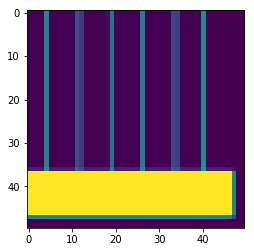

In [19]:
plt.imshow(resized_contactsMask)

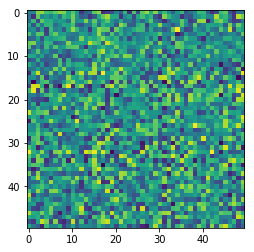

In [20]:
plt.imshow(resized_illuminationMask)

## Set solar cell parameters

In [21]:
# Size of the pixels (m)
Lx = 10e-6
Ly = 10e-6

# Height of the metal fingers (m)
h = 2.2e-6

# Contact resistance (Ohm m2)
Rcontact = 3e-10

# Resistivity metal fingers (Ohm m)
Rline = 2e-8

# Bias (V)
vini = 0
vfin = 3
step = 0.01

T = 298

## Set the parameter of solar cells

In [22]:
ingap_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=0.66, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                       R_shunt=1e16, n=3.5)
gaas_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=1.4, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                        R_shunt=1e16, n=3.5)
ge_cell = Junction(kind='2D', T=T, reff=0.5, jref=300, Eg=1.8, A=1, R_sheet_top=100, R_sheet_bot=100,
                        R_shunt=1e16, n=3.5)

my_solar_cell = SolarCell([gaas_cell], T=T)

### Set the light source

In [23]:
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl, output_units='photon_flux_per_m',
                           concentration=100)

options = {'light_iv': True, 'wavelength': wl, 'light_source': light_source}

### Launch the solver

In [24]:
V, I, Vall, Vmet = solve_quasi_3D(my_solar_cell, resized_illuminationMask, resized_contactsMask, options=options, Lx=Lx, Ly=Ly, h=h,
                                  R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini, bias_end=vfin,
                                  bias_step=step)

# Since we model 1/4 of the device, we multiply the current by 4
I = I * 4

Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
... Done!!


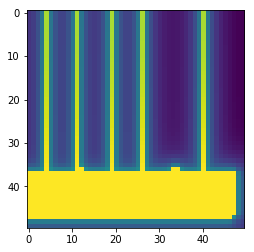

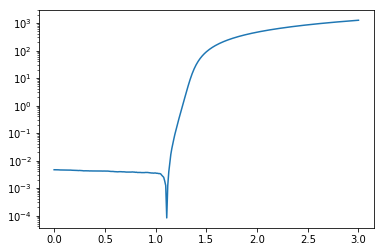

In [25]:
plt.figure(1)
plt.imshow(Vall[:, :, -2, -1])

plt.figure(2)
plt.semilogy(V, abs(I))
plt.show()

## Plot in linear scale

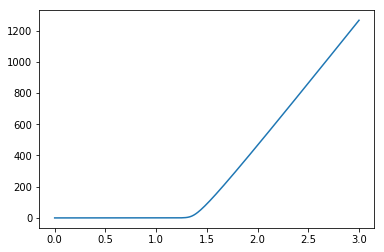

In [26]:
plt.plot(V, I)

## Export the I-V characteristics into a CSV file

In [27]:
output_iv=np.vstack([V,I]).T
np.savetxt('iv_result.csv',output_iv,delimiter=',')